# <span style="color:red">__Explainability: Plan__</span>
1. <span style="color:red">__[done]__</span> Local explainability (why did this specific prediction happen?) - SHAP
2. <span style="color:red">__[done]__</span> Global explainability (feature importance across entire dataset) - SHAP & summary plots (GameTheory-based prediction<>feature link)
3. <span style="color:red">_[wip]_</span> Local explainability (why did this specific prediction happen?) - LIME
4. <span style="color:red">_[wip]_</span> Counterfactuals (what's the min change to the input that'd change the decision?”) - DiCE

| Use Case                    | Description                                                                        |
| --------------------------- | ---------------------------------------------------------------------------------- |
| **Audit Trails**            | Trace how/why a decision made, and if it'd be different under slight input changes |
| **Fairness/Bias Detection** | Analyze if sensitive attributes (race, gender) unfairly affect outcome             |
| **Recourse Planning**       | Provide users with actionable steps they can take to receive a favorable decision  |
| **Robustness Testing**      | Check if small perturbations cause unexpected model behavior                       |

___
__Additionally:__
1) <span style="color:red">_[wip]_</span> Surrogate models (e.g., decision tree explaining a neural net)
2) <span style="color:red">_[wip]_</span> Model debugging (detect bias or instability)

# ✅ 1. SHAP for Local Explainability

## 1. Context
We use a model to predict whether an individual earns more than $50K per year based on features such as age, education, hours worked per week, etc.

We're interested in **why** the model made a specific prediction for one person. This is **local explainability**.


## 2. Goal
We want to decompose a single prediction into contributions from each input feature, answering:
> "Which features pushed the prediction up or down?"

**Tool used**: SHAP (SHapley Additive exPlanations)  
**Type**: Local explainability

## 3. Math Logic
SHAP assigns each feature a “Shapley value” — its average marginal contribution across all possible combinations of features (coalitions):

$$\phi_i = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|!(|F| - |S| - 1)!}{|F|!} \left[ f(S \cup \{i\}) - f(S) \right]$$

This provides a fair and consistent way to attribute importance.

## 4. Code and Waterfall Plot
We train an XGBoost model and use SHAP to explain one specific prediction.

shap_values.shape: (520, 14)
E[f(x)] = average log-odds prediction across the dataset = -1.246, i.e. probability = 0.223
Person 0 raw log-odds prediction for this specific person = -0.038, i.e. probability = 0.491


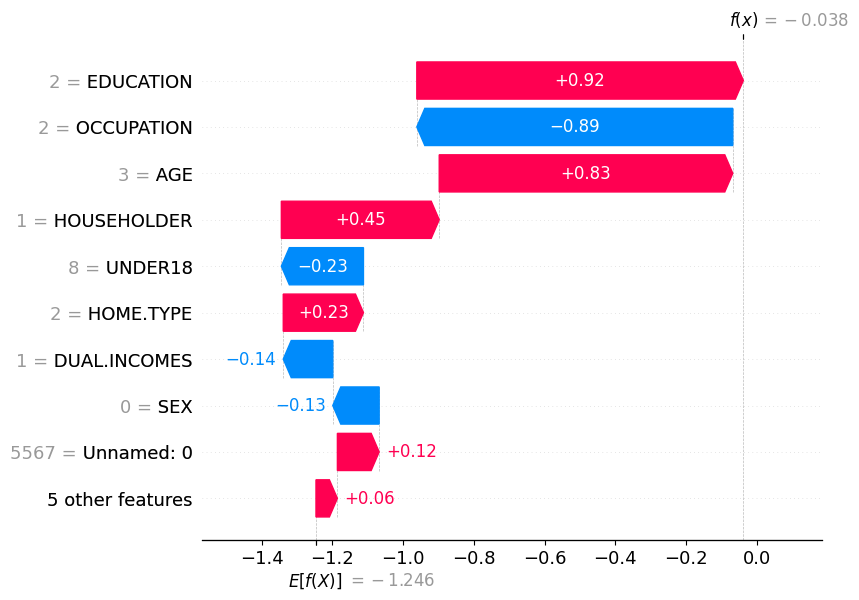

In [4]:
import shap
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np

# Load dataset
if not os.path.exists('data/income.csv'):
    url = "https://raw.githubusercontent.com/selva86/datasets/master/income.csv"
    pd.read_csv(url).to_csv('data/income.csv')
df = pd.read_csv('data/income.csv')

# Basic preprocessing
df = df.dropna()
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Example threshold: classes 7 and 8 are "high income", others are low
df['INCOME_BINARY'] = df['INCOME'].apply(lambda x: 1 if x in [7,8] else 0)
X = df.drop(['INCOME', 'INCOME_BINARY'], axis=1)
y = df['INCOME_BINARY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBClassifier(eval_metric='logloss', objective='binary:logistic')
model.fit(X_train, y_train)

# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# Waterfall plot for row i, class 1 (income > 50K)
i = 0
print(f'shap_values.shape: {shap_values.shape}')         # (n_samples, n_features)
Efx = shap_values[i].base_values  # baseline
fx = Efx + shap_values[i].values.sum()  # log_odds_pred
print(f'E[f(x)] = average log-odds prediction across the dataset = {Efx:.3f}, i.e. probability = {1 / (1 + np.exp(-(Efx))):.3f}')
print(f'Person {i} raw log-odds prediction for this specific person = {fx:.3f}, i.e. probability = {1 / (1 + np.exp(-(fx))):.3f}')

shap.plots.waterfall(shap_values[0])

__What we got:__
- A waterfall plot showing which features pushed the prediction up/down.
- "Local explainability" for a single prediction.

__Result:__  
`f(x) = -0.038`  
`E[f(x)] = -1.246`

__Interpretation:__
1. $E[f(x)]$ is the expected model output over the entire training set.
- For XGBoost with binary:logistic, SHAP computes raw model outputs before applying the logistic function (sigmoid).
- So $E[f(x)]$ = -1.246 means: the average log-odds prediction across the dataset is -1.246.
We can convert it to probability: ${1\over1+e^{-(-1.246)}}\approx0.223$, so, the average predicted probability of income >50K across all people is 22.3%.
2. $f(x)$ is the model's raw log-odds prediction for this specific person (row 0).
$f(x) = -0.038$ is very close to $0$ → almost neutral. So for this person, the model predicts ~49.0% chance that income > 50K.




# ✅ 2. SHAP for global explainability

We also create SHAP-based global feature importance: `shap.plots.bar(explainer(X_test))`  
This bar plot aggregates the absolute SHAP values (per feature, across all rows in X_test) and shows:  
_"On average, how much does this feature contribute (positively or negatively) to the model’s output prediction across the dataset?"_

This is "Global", because:
- It looks at all samples, not just one.
- It reflects how consistently impactful each feature is on the predictions.
- It's model-specific and much more informative than raw model.feature_importances_.

importance: [0.77112424 0.1929097  0.1877232  0.920365   0.46992362 0.6167679
 0.10763398 0.2307758  0.23708041 0.19488841 0.51704466 0.52957666
 0.22827578 0.04609856]


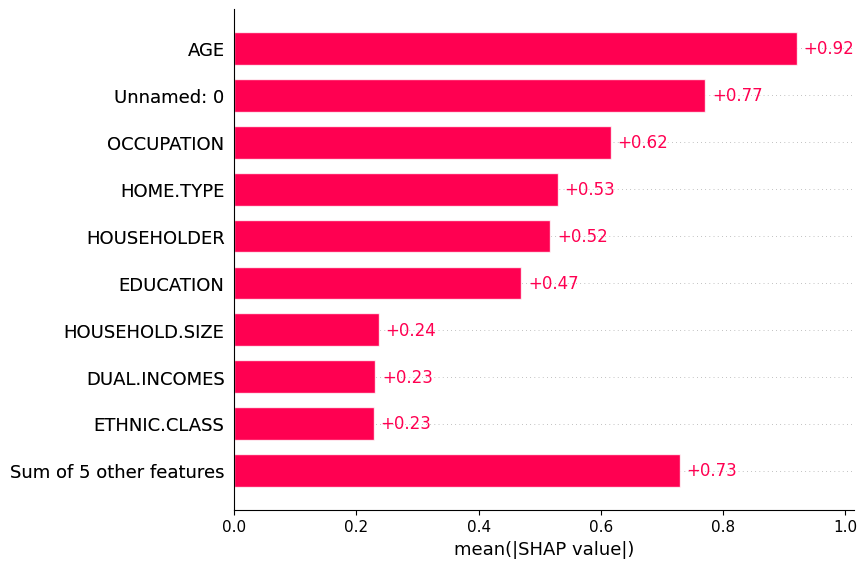

In [5]:
importance = np.mean(np.abs(shap_values.values), axis=0)
print(f'importance: {importance}')
shap.plots.bar(explainer(X_test))

It shows the Mean SHAP per feature (importance only) - i.e. Global level.

🧠 Quick Interpretability Example:
If 'AGE' is top-ranked in the SHAP bar plot:
- It means AGE consistently has a strong influence on the model's predicted income class (high or low).
- Doesn't matter if SHAP values are positive or negative - just that they're large in magnitude.

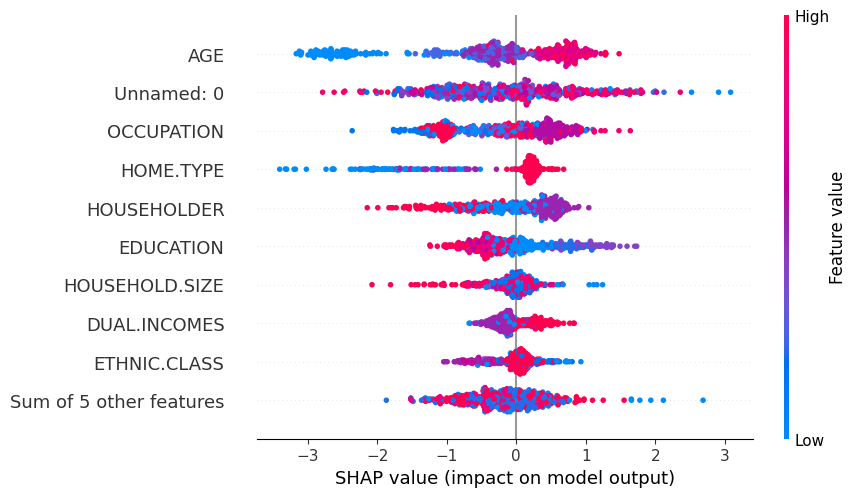

In [6]:
shap.plots.beeswarm(shap_values)

| Plot Type                              | What It Shows                           | Level                  |
| -------------------------------------- | --------------------------------------- | ---------------------- |
| `shap.plots.bar`                       | Mean SHAP per feature (importance only) | Global                 |
| `shap.plots.beeswarm`                  | Distribution of SHAP values by feature  | Global + Local details |

The second plot (`beeswarm`) shows:
- Spread and direction of SHAP values for each feature.
- Which feature values push predictions up/down.
- Outliers and nonlinear effects.

__Interpretation:__
1. Each point is a single observation (i.e., one row/person from your test dataset). So for feature AGE, you’ll see one dot per person — each dot showing how much their age contributed to the model’s prediction.
2. 🎨 Color = the actual feature value for that person (before SHAP transformed it).
- Red = High value (e.g., old age)
- Blue = Low value (e.g., young age)  
  - _“This person had high age (red), and that made their SHAP value +1.2 for ‘high income’ prediction.”_
  - It gives semantic meaning: you can see whether high or low values tend to push the prediction up or down.
3. The horizontal spread (-3 to +1.5) is its SHAP value range
- That is the range of SHAP values for that feature across all people — i.e., how much AGE contributes (positively or negatively) to the predicted log-odds.
- So here:
  - Some people’s AGE reduced their prediction (left of 0)
  - Some people’s AGE increased their prediction (right of 0)
4. Direction = the effect of that feature value on the prediction
- Left of 0 → Negative SHAP value → pushes prediction lower
- Right of 0 → Positive SHAP value → pushes prediction higher  
Think of this as: _Does this person’s value for this feature nudge the model toward saying "income = high"? Or away from it?_
5. “Which feature values push predictions up/down - is this about positive vs negative SHAP values:
- If SHAP value < 0: That feature value is reducing the prediction (probability of high income).
- If SHAP value > 0: That feature value is increasing it.  
Look at blue dots on left - that means low values decrease the prediction.  
Look at red dots on right - that means high values increase it.  
6. Non-linear effects: the same feature (e.g., AGE) doesn't always behave the same way: sometimes high AGE increases prediction, other times it decreases it.  
- Example pattern:
  - Red dots on both left and right: means high AGE pushes prediction up in some people, but down in others
  - That suggests AGE’s effect depends on context (e.g., other features)  
- A linear model wouldn’t allow this: in linear models, a high feature value always increases or decreases prediction the same way. So:
  - Beeswarm plot shows non-linearity if same-colored points (esp. red) appear on both sides of zero.
  - That means model learned interactions or threshold effects.


| Feature of Beeswarm    | What it Means                                                       |
| ---------------------- | ------------------------------------------------------------------- |
| Each dot               | One person (one row of `X_test`)                                    |
| X-axis                 | SHAP value: how much this feature affected that person's prediction |
| Color                  | Actual value of the feature (red = high, blue = low)                |
| Left of 0              | Pushes prediction *down*                                            |
| Right of 0             | Pushes prediction *up*                                              |
| Red dots on both sides | Feature has non-linear or interaction effects                       |


# ✅ 3. LIME (Local Interpretable Model-Agnostic Explanations)
- we'll compare it to SHAP for local interpretability.

In [9]:
# ! pip install lime
# ! pip install IPython

In [14]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# LIME expects numpy arrays
X_train_np = X_train.values
X_test_np = X_test.values

# Set up LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X.columns.tolist(),
    class_names=['Low Income', 'High Income'],
    mode='classification'
)

# Explain a prediction
i = 0  # index of instance to explain
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_np[i],
    predict_fn=model.predict_proba,
    num_features=10
)

# Show explanation
lime_exp.show_in_notebook()

ImportError: cannot import name 'display' from 'IPython.core.display' (e:\anaconda3\envs\menv\Lib\site-packages\IPython\core\display.py)

✅ Step 3: What to Look For
Compare to SHAP:
| Concept             | SHAP                            | LIME                         |
| ------------------- | ------------------------------- | ---------------------------- |
| Model Compatibility | Model-specific & model-agnostic | Model-agnostic               |
| Output              | Additive SHAP values            | Weighted local linear model  |
| Local Fidelity      | Exact (from tree logic)         | Approximate (from surrogate) |
| Feature Impact      | Consistent (game theory)        | Varies with perturbations    |


✅ Step 4: Next Steps
- Deep dive into the math and intuition behind LIME (incl. linear surrogate models)
- Visualize and compare SHAP vs. LIME for the same row